# Problem Set 2 - Decision Trees and Ensemble Methods
## CSCI 4622 - Spring 2023

***
**Name**: Alex Ojemann
***

This assignment is due on Canvas by **11:59PM on February 22nd**.

Submit only this Jupyter notebook to Canvas. Do not compress it using tar, rar, zip, etc.
Your solutions to analysis questions should be done in Markdown directly below the associated question.

Remember that you are encouraged to discuss the problems with your classmates and instructors,
but **you must write all code and solutions on your own**, and list any people or sources consulted.
The only exception to this rule is that you may copy code directly from your own solution to homework 1 or labs.


## Overview 

Your task for this homework is to build a decision tree classifier from scratch. Of course, we provide some initial classes that you'll be editing.
Since the other two problems will use the scikit-learn's DecisionTreeClassifier, your solution does not have to be efficient as long as it passes the sanity checks in a reasonable time (typically less than ~1min).

The last problem requires a _weak learner_, so we'll use a decision tree that yields low performance. But with _Ensemble Methods_, we will be able to improve the performance by aggregating predictions from multiple weak learners.
For the ensemble methods, we'll explore bagging, Random Forest, and boosting (AdaBoost).

Any Machine Learning interview will almost certainly have a question or two about decision trees and how they're trained.
So understanding the code and trying to implement everything on your own will be the best way to prepare for such interviews.

Also remember, if your code is correct then the sanity checks should pass without any major issue.
But if the sanity checks pass that does not necessarily imply your code is 100% correct.

Happy coding!

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
import helpers
from scipy import stats as st
%matplotlib inline

## Problem 1 - Decision Trees [50 points + 4 points]
***
The goal of this problem is to implement the core elements of the Decision Tree classifier.
We do not expect a highly efficient implementation of the functions since we will be using the implementation from scikit-learn in later problems.

We'll be testing our implementation on a simple toy dataset:

|Age|Income|Single| Has Pets | College Degree|
|:------:|:-----------:| :----------:| :----------:|:--:|
|20| 37000| 1| 0|0|
|32| 50000| 0| 0|0|
|24| 46000| 1| 1|0|
|28| 52000| 1| 1|1|
|28| 28000| 0| 1|0|
|22| 54000| 0| 1|1|
|28| 50000| 0| 0|1|
|26| 36000| 0| 0|1|
|24| 45000| 1| 1|0|
|33| 45000| 0| 0|1|
|34| 50000| 1| 1|0|
|29| 51000| 1| 0|1|

In [2]:
features = np.array([[20, 37000, 1, 0],
                     [32, 50000, 0, 0],
                     [24, 46000, 1, 1],
                     [28, 52000, 1, 1],
                     [28, 28000, 0, 1],
                     [22, 54000, 0, 1],
                     [28, 50000, 0, 0],
                     [26, 36000, 0, 0],
                     [24, 45000, 1, 1],
                     [33, 45000, 0, 0],
                     [34, 50000, 1, 1],
                     [29, 51000, 1, 0]])
labels = np.array([0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1])


Each leaf node (terminal node) in a decision tree has a label value assigned to it. The same label will be assigned to all samples that reach the leaf node during the prediction.

**Q1.1** [5 points] Complete `compute_label` to return the label that should be assigned to the leaf node based on training labels in `y`.
If more than one label are possible, choose the one with the lowest value (e.g, if both `0` and `1` are equally likely, choose `0`)

In [3]:
def compute_label(node_labels):

    # Workspace 1.1
    # TODO: Return the label that should be assigned to the leaf node
    # In case of multiple possible labels, choose the one with the lowest value
    # Make no assumptions about the number of class labels
    label = None
    # BEGIN 
    # code here
    label = (min(st.mode(node_labels)[0]))
    # END
    return label

We provide below the LeafNode implementation

In [4]:
class LeafNode:
    def __init__(self, node_labels):
        """ Initialize the leaf node
        Args:
            y: 1-d array containing labels, of shape (num_points,)
        """
        self.label = compute_label(node_labels)

    @staticmethod
    def is_terminal():
        return True

    def predict(self, X):
        return self.label * np.ones(X.shape[0])

In [5]:
%run -i tests leaf

/tmp/ipykernel_134/1415025835.py:10: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  label = (min(st.mode(node_labels)[0]))
.
----------------------------------------------------------------------
Ran 1 test in 0.002s

OK



The tree also contains _decision nodes_. They can either be parents of: leaf nodes, decision nodes, or a combination of the two.

Each decision node has a left and a right child. A node is branched out (parent node) **when we can reduce the uncertainty** by splitting
the training instances based on a certain threshold.

First, we'll need to choose a uncertainty measure. For this problem, we will use _entropy_ (scikit uses gini by default).

\begin{align}
\text{Entropy}(y) = - \sum_{c}  p_c \log_2(p_c)
\end{align}

where $p_c$ is the probability of occurrence (ratio)  of class $c$ among the labels in $y$

**Q1.2** [5 points] Complete the function `entropy` that returns the entropy measure of labels in `y`.

_Hint:We use the convention `0 * log(0) = 0`. Make sure you handle multi-class labels (not just binary) and une `np.log2` (log base 2)_


In [6]:
def entropy(y):
    """
    Args:
        y: 1-d array contains labels, of shape (num_points,)
    Returns: float, entropy measure of the values in y
    """
    entropy_value = 0
    # Workspace 1.2
    # TODO: Compute the entropy of the labels
    # BEGIN 
    # code here
    # Compute the counts of each label in y
    unique_labels, label_counts = np.unique(y, return_counts=True)
    
    # Compute the proportion of points with each label
    label_probs = label_counts / len(y)
    
    # Compute the entropy using the formula
    for prob in label_probs:
        entropy_value -= prob * np.log2(prob)
    # END
    return entropy_value

In [7]:
# Test cell, uncomment to run the tests
%run -i tests entropy

.
----------------------------------------------------------------------
Ran 1 test in 0.001s

OK


When we create a decision node, we decide to split our samples $T$ to two parts $T_L$ and $T_R$, and we want to compute how much this split reduces the uncertainty (entropy).

**Q1.3** [5 points] Using the uncertainty measure $\mathcal{u}$, what is the expression of the expected uncertainty reduction if we split $T$ into $T_L, T_R$ ?

You can use LaTeX markdown to [type the equations](https://www.fabriziomusacchio.com/blog/2021-08-10-How_to_use_LaTeX_in_Markdown/)

##### Workspace 1.3

#BEGIN

Uncertainty Reduction $= u(T) - \frac{|T_L|}{|T|}u(T_L) - \frac{|T_R|}{|T|}u(T_R)$


#END

In [8]:
def uncertainty_reduction(y, left_indices, right_indices):
    """
    Args:
        y: all labels
        left_indices: the indices of the elements of y that belong to the left child
        right_indices: the indices of the elements of y that belong to the right child
    Returns: uncertainty reduction of the split
    """
    reduction = 0
    # Workspace 1.4
    # BEGIN 
    # code here

    original_entropy = entropy(y)

    left_labels = y[left_indices]
    right_labels = y[right_indices]
    left_entropy = entropy(left_labels)
    right_entropy = entropy(right_labels)
    
    left_size = len(left_indices)
    right_size = len(right_indices)
    total_size = left_size + right_size

    reduction = original_entropy - (left_size/total_size)*left_entropy - (right_size/total_size)*right_entropy

    # END
    return reduction

In [9]:
# Test cell, uncomment to run the tests
%run -i tests reduction

.
----------------------------------------------------------------------
Ran 1 test in 0.001s

OK


We'll use `best_split` to look up for the feature and threshold that yields the partition with the best uncertainty reduction.

- For each feature:
    - Compute all possible thresholds (use `split_values`)
    - For each threshold:
        - Split to `(left_indices, right_indices)` based on the threshold
        - Compute the uncertainty reduction of the split
- Returns the feature and the threshold that yield the highest uncertainty reduction (and the reduction value)
<br>

**Q1.5** [8 points] Complete `best_split`. In case there are multiple possible solutions, return the first one encountered.
 
 _Hint: `split_values` is provided as a helper function. It takes the feature column and returns the set of thresholds. Use print to display the behavior if still not clear_

In [10]:
def split_values(feature_values):
    """ Helper function to return the split values. if feature consists of the values f1 < f2 < f3 then
    this returns [(f2 + f1)/2, (f3 + f2)/2]
    Args:
        feature_values: feature_values: 1-d array of shape (num_points)
    Returns:  array of shape (max(m-1, 1),) where m is the number of unique values in feature_values
    """
    unique_values = np.unique(feature_values)
    if unique_values.shape[0] == 1:
        return unique_values
    return (unique_values[1:] + unique_values[:-1]) / 2


def best_split(X, y):
    """ Find the feature id, threshold, indices, and reduction for the best split
    Args:
        X: features array, shape (num_samples, num_features)
        y: labels of instances in X, shape (num_samples)
    Returns: the best split related information.
    """

    best_feature_id, best_threshold, best_left_indices, best_right_indices = None, None, None, None
    best_reduction = -np.inf

    # Workspace 1.5
    # TODO: Complete the function as detailed in the question and return description
    for feature_id in range(X.shape[1]):
        for threshold in split_values(X[:, feature_id]):
        # BEGIN 
        # code here
            left_indices = np.where(X[:, feature_id] <= threshold)[0]
            right_indices = np.where(X[:, feature_id] > threshold)[0]
            
            if len(left_indices) == 0 or len(right_indices) == 0:
                continue

            reduction = uncertainty_reduction(y, left_indices, right_indices)
            
            if reduction > best_reduction:
                best_feature_id = feature_id
                best_threshold = threshold
                best_left_indices = left_indices
                best_right_indices = right_indices
                best_reduction = reduction
        # END
    return best_feature_id, best_threshold, best_left_indices, best_right_indices, best_reduction

In [11]:
# Test cell, uncomment to run the tests
# If you chose to not use split_values, then this test will likely fail
%run -i tests split

.
----------------------------------------------------------------------
Ran 1 test in 0.002s

OK


Note that the `left_child` will take instance for which`feature_id` value is <= `feature_threshold`. We should construct our decision tree as such.
We define the DecisionNode class below:

In [85]:
class DecisionNode:
    def __init__(self, feature_id, threshold, left_child, right_child):
        self.feature_id = feature_id
        self.threshold = threshold
        self.left = left_child
        self.right = right_child

    @staticmethod
    def is_terminal():
        return False

    def add_importance(self, importances: dict, X, y):
        # Workspace 1.10
        # Bonus question
        # Note that dictionaries are passed by reference and not by value
        # BEGIN 
        # code here
        if self.is_terminal():
            return importances

        reduction = uncertainty_reduction(y, np.where(X[:, self.feature_id] <= self.threshold)[0], np.where(X[:, self.feature_id] > self.threshold)[0])

        N = len(node_indices)  # number of samples that belong to this node, couldn't figure out how to find this
        importances[self.feature_id] += N * reduction

        left_indices = np.where(X[node_indices, self.feature_id] <= self.threshold)[0]
        right_indices = np.where(X[node_indices, self.feature_id] > self.threshold)[0]

        self.left.add_importance(importances, X, y, node_indices[left_indices])
        self.right.add_importance(importances, X, y, node_indices[right_indices])


        # END
        return importances
    def predict(self, X):
        y_pred = np.zeros((X.shape[0]))
        left_indices = np.where(X[:, self.feature_id] <= self.threshold)[0]
        right_indices = np.where(X[:, self.feature_id] > self.threshold)[0]
        y_pred[left_indices] = self.left.predict(X[left_indices])
        y_pred[right_indices] = self.right.predict(X[right_indices])
        return y_pred

Now we tackle the core of a decision tree. The tree is built in a recursive way. The recursion in `build_tree` works as follows:
- Parameters: `min_samples_split`, `depth`
- Inputs: `X`, `y`
- Base case of the recursion, return a leaf node if either:
    - `depth` is 0
    - `y` contains less than `min_samples_split` elements
    - There is no uncertainty reduction (reduction<=0 for all splits)
- Recursion (there is a split with reduction > 0):
    - create a decision node with left and right child nodes with `depth - 1`
    - return the decision node

The left child node will contain instances for which the feature with index `best_feature` is <= than
`best_threshold` of the split. The right child takes the remaining instances.


**Q1.6** [10 points] Complete `build_tree` method


In [86]:
def build_tree(X, y, depth=-1, min_samples_split=2):
    if depth == 0 or len(y) < min_samples_split:
        # we reached the maximum depth or we don't have more than the minimum number of samples in the leaf
        tree = LeafNode(y)
    else:
        # Get the feature, threshold and information_gain of the best split
        feature_id, threshold, left_indices, right_indices, reduction = best_split(X, y)
        # reduction = 0 occurs when the labels have the same distribution in the child nodes
        # which means that the entropy of the children is the same as the parent's so we don't need to split
        # Workspace 1.6
        # TODO: if needed, create the left and right child nodes with depth - 1, return the decision node
        # BEGIN 
        # code here
        if reduction == 0:
            tree = LeafNode(y)
        else:
            left_tree = build_tree(X[left_indices], y[left_indices], depth - 1, min_samples_split)
            right_tree = build_tree(X[right_indices], y[right_indices], depth - 1, min_samples_split)
            tree = DecisionNode(feature_id, threshold, left_tree, right_tree)
        # END
    return tree

**Q1.7** [4 points] Complete the `score` method that returns the accuracy on the given data (you can use `sklearn.metrics`)

In [87]:
class DecisionTree:

    def __init__(self, max_depth=-1, min_samples_split=2):
        """ Initialize the decision tree
        Args:
            max_depth: maximum depth of the tree
            min_samples_split: minimum number of samples required for a split
        """
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.tree = None
        self.num_features = None

    def fit(self, X, y):
        """
        Args:
            X: Training samples
            y: training labels
        Return:
             trained decision tree
        """
        self.tree = build_tree(X, y, self.max_depth, self.min_samples_split)
        return self

    def predict(self, X):
        """
        Loops through rows of X and predicts the labels one row at a time
        """
        return self.tree.predict(X)

    def feature_importance(self, X, y):
        """ Compute the importance of each feature in the decision tree
         Only relevant to the bonus question
        """
        feat_importance = {k:0 for k in range(X.shape[1])}
        if not self.tree.is_terminal():
            self.tree.add_importance(feat_importance, X, y)
        feat_importance = {k: v/sum(feat_importance.values()) for k,v in feat_importance.items()}
        return feat_importance

    def score(self, X, y):
        """ Return the mean accuracy on the given test data and labels.
        Args:
            X: Test samples, shape (num_points, num_features)
            y: true labels for X, shape (num_points,)
        Return:
            mean accuracy
        """
        accuracy = 0
        # Workspace 1.7
        # BEGIN 
        # code here
        for i in range(X.shape[0]):
            if self.predict(X)[i] == y[i]:
                accuracy += 1
        accuracy /= X.shape[0]
        # END
        return accuracy

In [88]:
# Test cell, uncomment to run the tests
# If you chose to not use split_values, then this test will likely fail
%run -i tests build

/tmp/ipykernel_134/1415025835.py:10: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  label = (min(st.mode(node_labels)[0]))
.
----------------------------------------------------------------------
Ran 1 test in 0.007s

OK


**Q1.8** [4 points] Using `min_samples_split=2`, what is the minimum depth so that our `DecisionTree` fits perfectly our dataset `(features, labels)`.

In [89]:
# Workspace 1.8
# To show that the minimum required depth is n, you can provide the accuracy for depth = (n-1) and depth = n
# BEGIN 
# code here
#Depth n (n=4 because there's 4 features)
d = DecisionTree()
d.fit(features,labels)
print(d.score(features,labels))
#Depth n - 1 (n-1=3 because there's 4 features)
e = DecisionTree(max_depth=3)
e.fit(features,labels)
print(e.score(features,labels))
# END

1.0
0.9166666666666666


/tmp/ipykernel_134/1415025835.py:10: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  label = (min(st.mode(node_labels)[0]))


We provide an example below to display the structure of a decision tree.

**Q1.9** (4points) Edit it to show the tree for the required minimum depth found in 1.8

In [90]:
tree = DecisionTree(max_depth=3, min_samples_split=2).fit(features, labels)
helpers.print_tree(tree, ["age", "income", "single", "has_pets"])
# BEGIN 
# code here
tree = DecisionTree(max_depth=4, min_samples_split=2).fit(features, labels)
helpers.print_tree(tree, ["age", "income", "single", "has_pets"])
# END

                              ┌│label: 0
                   ┌|income  │L
                   │|32000.00│R
                   │          └│label: 1
          ┌|single│L
          │|0.50  │R
          │        └│label: 0
|income  │L
|50500.00│R
          └│label: 1
                              ┌│label: 0
                   ┌|income  │L
                   │|32000.00│R
                   │          │       ┌│label: 1
                   │          └|age  │L
                   │           |30.00│R
                   │                  └│label: 0
          ┌|single│L
          │|0.50  │R
          │        └│label: 0
|income  │L
|50500.00│R
          └│label: 1


/tmp/ipykernel_134/1415025835.py:10: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  label = (min(st.mode(node_labels)[0]))


#### Bonus
Now we can be a bit more ambitious and compute the importance of each feature in our decision tree. The importance of feature $f$
is the sum of the weighted uncertainty reduction of decision nodes that are split based on the feature $f$.

The weighted uncertainty reduction of $node_i$ is the following:

\begin{align}
\frac{N_{\text{node}_i}}{N_\text{total}} \times \textrm{Reduction}({\text{node}_i}),
\end{align}

where $N$ is the total number of training samples, and $N_{\text{node}_i}$ is the number of training samples that reach the decision node $node_i$.

Since we scale the feature importances in `DecisionTree` to sum to 1, we don't have to divide by $N_\text{total}$
and we can simply use:

\begin{align}
\text{weighted reduction}(\text{node}_i) = N_{\text{node}_i} \times \textrm{Reduction}({\text{node}_i}),
\end{align}

Practically, we use a dictionary `feat_importance` that maps feature indices to their importances.
- Start with `feat_importance[f]=0` for all `f`
- Start the recursion from the root node:
    - Current node is split based on feature `i`
    - add weighted uncertainty reduction to `feat_importance[i]`
    - ask right and left child to do the same
- Scale the values in `feat_importance` to sum to 1
- return `feat_importance`


**(Bonus)Q1.10** [4 points] Complete `DecisionNode`'s `feature_importance`


In [91]:
# Uncomment to test
%run -i tests importance

/tmp/ipykernel_134/1415025835.py:10: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  label = (min(st.mode(node_labels)[0]))
E
ERROR: test_importance (__main__.TestDT)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "/home/jovyan/PS2/tests.py", line 99, in test_importance
    importance = tree.feature_importance(features, labels)
  File "/tmp/ipykernel_134/2850605461.py", line 37, in feature_importance
    self.tree.add_importance(feat_importance, X, y)
  File "/tmp/ipykernel_134/1801639198.py", line 23, in add_importance
    N = len(node_indices)  # number of sam

## Problem 2 - Decision Tree Ensembles [50 points]
---


We've seen that a DecisionTreeClassifier with depth = 3 is far from being the best performing on our house prices data.

In this problem, we will introduce 3 ensemble methods to _boost_ the performance of this poor and underestimated weak learner.

First, we'll need a fancier dataset. We are going to predict house price levels using the decision trees.

We start by loading preprocessed data that we'll use. Since the original House Prices [dataset](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data) is for regression, we have to transform `HousePrices.y` to discrete values reflecting price level.

|Price range| Label|
|:----------:|--:|
| $ P < $125000|0|
|125000$\leq P < $ 160000| 1 |
|160000$ \leq P < $ 200000| 2 |
|200000$ \leq P $ | 3 |


**Q2.1** [4 points] Transform `house_prices.y` following the table above


In [21]:
import data

house_prices = data.HousePrices()
# Workspace 2.1
# TODO: Discretize house_prices.y
# BEGIN 
# code here
priceBins = []
for price in house_prices.y:
    if(price < 125000):
        priceBins.append(0)
    elif(price < 160000):
        priceBins.append(1)
    elif(price < 200000):
        priceBins.append(2)
    else:
        priceBins.append(3)
house_prices.y = priceBins
# END
print(np.unique(house_prices.y), house_prices.X.shape)

[0 1 2 3] (1458, 79)


In [22]:
%run -i tests discretize

.
----------------------------------------------------------------------
Ran 1 test in 0.001s

OK


In [23]:
tree = DecisionTreeClassifier(max_depth=3, min_samples_leaf=0.1).fit(house_prices.X, house_prices.y)
print("Accuracy on training set:", tree.score(house_prices.X, house_prices.y))

Accuracy on training set: 0.6625514403292181


The cell above show that even when evaluated on the training data, a decision tree of depth 3 does not perform well

Whenever we need to generate a new instance of our weak learner, we'll have to call `get_weak_leaner`.

In [24]:
def get_weak_learner():
    """Return a new instance of out chosen weak learner"""
    return DecisionTreeClassifier(max_depth=3, min_samples_leaf=0.1)

Start by completing the `Evaluator` class that we'll use to evaluate different ensemble methods.


**Q2.2** [6 points] Complete the `evaluate_model` class to fit the model received as parameter and store the accuracy and running time.

Since we don't have a validation set, you have to use [StratifiedKFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html) (`self.k_fold`) to perform a 3-fold cross validation and store the weighted average precision over the 3 folds

You can use the function `plot_metrics` to show and compare different statistics of each model in a bar chart.



In [25]:
from time import time
from sklearn.model_selection import StratifiedKFold
import pandas as pd


class Evaluator:
    """
        Test multiple model performance
    """

    def __init__(self, dataset):
        """ Initialize Evaluator
        Args:
            dataset: dataset containing Training and Test sets
        """
        self.dataset = dataset
        self.execution_time = {}  # dictionary with key: model name, value: time taken to fit and score the model
        self.scores = {}  # dictionary with key: model name, value: weighted average precision
        self.score_name = 'WAP'
        self.k_fold = StratifiedKFold(3, shuffle=True, random_state=42)

    def evaluate_model(self, model, name):
        """ Fit the model using the training data and save the evaluation score on the test fold
        Args:
            model: classifier to evaluate, has fit and predict methods
            name: name of model
        """
        start = time()
        # Workspace 2.2
        # TODO: Fit the model on 3 different folds and store the average accuracy in self.score[name]
        # BEGIN 
        # code here
        score_sum = 0
        for train_indices, test_indices in self.k_fold.split(self.dataset.X, self.dataset.y):
            X_train, X_test = self.dataset.X[train_indices], self.dataset.X[test_indices]
            #Wasn't able to index y until I converted it into an array
            self.dataset.y = np.array(self.dataset.y)
            y_train, y_test = self.dataset.y[train_indices], self.dataset.y[test_indices]

            model.fit(X_train, y_train)

            score = model.score(X_test,y_test)
            score_sum += score

        self.scores[name] = score_sum/3
        # END
        self.execution_time[name] = time() - start

    def print_results(self):
        """
            print results for all models trained and tested.
        """
        models_cross = pd.DataFrame({
            'Model': list(self.scores.keys()),
            self.score_name: list(self.scores.values()),
            'Execution time': list(self.execution_time.values())})
        print(models_cross.sort_values(by=self.score_name, ascending=False))

    def plot_metrics(self):
        """
        Plot bar chart, one for each statistic (metric, score, running time)
        """
        fig, axs = plt.subplots(1, 2)
        fig.set_figheight(6), fig.set_figwidth(18)
        p = 0
        for stats, name in zip([self.scores, self.execution_time],
                               [self.score_name, "Elapsed time"]):
            left = [i for i in range(len(stats))]
            height = [stats[key] for key in stats]
            tick_label = [key for key in stats]
            axs[p].set_title(name)
            axs[p].bar(left, height, tick_label=tick_label, width=0.5)
            p += 1
        plt.show()

**Q2.3** [3 points] Test `Evaluator.evaluate_model` using our weak learner returned by `get_weak_learner`

          Model       WAP  Execution time
0  Weak Learner  0.604252        0.017496


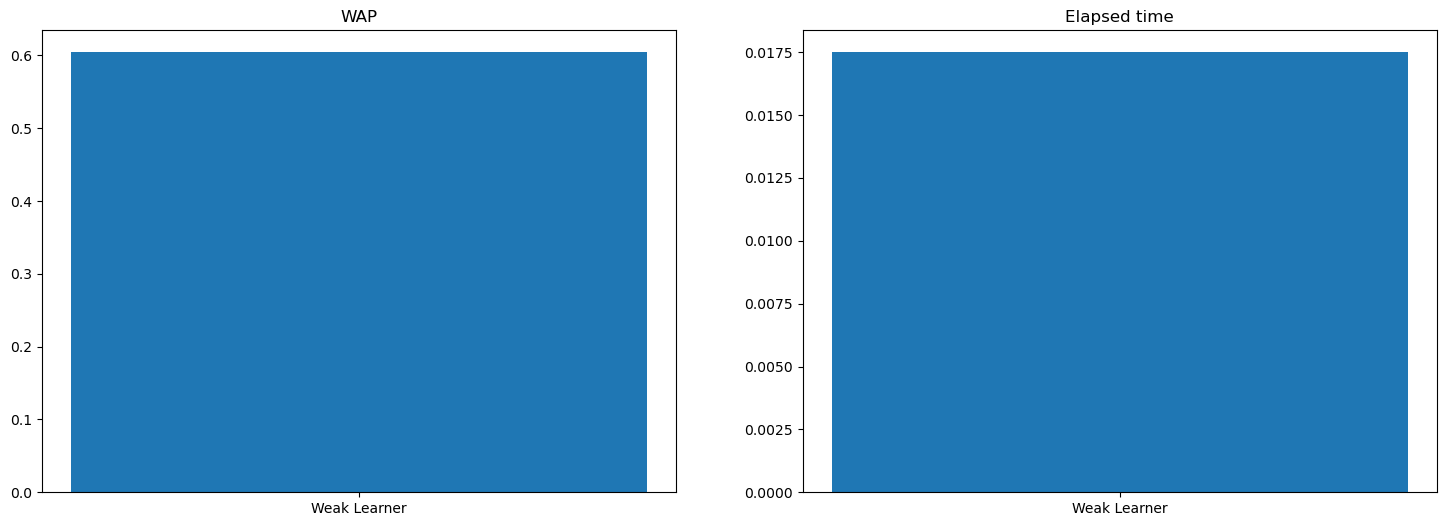

In [31]:
# create a handler for ensemble_test, use the created handler for fitting different models.
ensemble_handler = Evaluator(house_prices)
# Workspace 3.3
# TODO: Initialize weak learner and evaluate it using evaluate_model
# BEGIN 
# code here
ensemble_handler.evaluate_model(get_weak_learner(),"Weak Learner")
# END
ensemble_handler.print_results()
ensemble_handler.plot_metrics()

**Bagging:**

The first Ensemble technique we deal with is called _Bagging_ (Bootstrap AGGregatING).
Bagging consists of training a number of weak learners using randomly sampled instances from our data (**with replacement**). We have to start
by choosing the number of estimators we want to use. Then for each estimator, we sample a random subset of the data to fit the estimator.

To compute the prediction, we sum the prediction probabilities of the estimators and return the label that has the highest
accumulated probabilities.

**Q2.4** [5 points] First, complete `sample_data` to return a random sample of size `sample_ratio* len(X_train)` of features and labels

**Q2.5** [6 points] Complete `fit` by instantiating `n_estimators` of our weak leaner, each trained on random sample of the data

**Q2.6** [5 points] Complete `predict` method to return the most likely label by combining different estimators predictions.

Instead of the majority vote used in KNNClassifier, you should use `predict_proba` method of DecisionTreeClassifier.
[See Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier.predict_proba)

In [32]:
class BaggingEnsemble(object):

    def __init__(self, n_estimators, sample_ratio=1.0):
        """
        Initialize BaggingEnsemble
        :param n_estimators: number of estimators/weak learner to use
        :param sample_ratio: ratio of the training data to sample
        """
        self.n_estimators = n_estimators
        self.sample_ratio = sample_ratio
        self.estimators = []  # List used in fit method to store the trained estimators

    def sample_data(self, X_train, y_train):
        X_sample, y_sample = None, None
        # Workspace 2.4
        # TODO: sample random subset of size sample_ratio * len(X_train), sampling is with replacement (iid)
        # BEGIN 
        # code here
        n_samples = X_train.shape[0]
        n_samples_selected = int(self.sample_ratio * n_samples)
        indices = np.random.choice(n_samples, n_samples_selected, replace=True)
        X_sample = X_train[indices]
        y_sample = y_train[indices]
        # END
        return X_sample, y_sample

    def fit(self, X_train, y_train):
        """
        Train the different estimators on sampled data using provided training samples
        :param X_train: training samples, shape (num_samples, num_features)
        :param y_train: training labels, shape (num_samples)
        :return: self
        """
        np.random.seed(42)  # Keep it to get consistent results across runs, you can change the seed value
        self.estimators = []

        for _ in range(self.n_estimators):
            # Workspace 2.5
            # BEGIN 
            # code here
            X_sample, y_sample = self.sample_data(X_train, y_train)
            model = DecisionTreeClassifier()
            model.fit(X_sample, y_sample)
            self.estimators.append(model)
            # END
        return self

    def predict(self, X_test):
        """
        Predict the labels of test samples
        :param X_test: array of shape (num_points, num_features)
        :return: 1-d array of shape (num_points)
        """
        predicted_proba = 0
        answer = 0
        # Workspace 2.6
        # TODO: go through the trained estimators and accumulate their predicted_proba to get the mostly likely label
        # BEGIN 
        # code here
        for model in self.estimators:
            if predicted_proba is 0:
                predicted_proba = model.predict_proba(X_test)
            else:
                predicted_proba += model.predict_proba(X_test)
        answer = np.argmax(predicted_proba, axis=1)
        # END
        return answer

    def score(self, X, y):
        return np.mean(self.predict(X) == y)


<>:61: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:61: SyntaxWarning: "is" with a literal. Did you mean "=="?
/tmp/ipykernel_134/2362000647.py:61: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if predicted_proba is 0:


          Model       WAP  Execution time
1       Bagging  0.734568        0.307634
0  Weak Learner  0.604252        0.017496


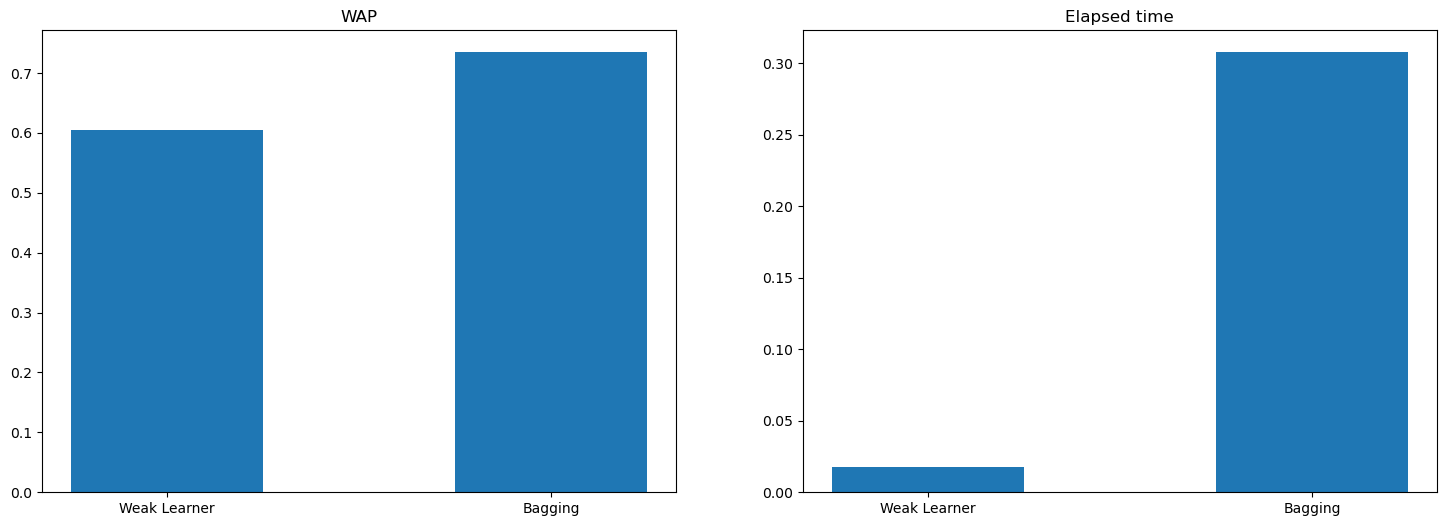

In [33]:
# This cell should run without errors
ensemble_handler.evaluate_model(BaggingEnsemble(10, 0.9), 'Bagging')
ensemble_handler.print_results()
ensemble_handler.plot_metrics()

### Random Forest

Random Forest has an additional layer of randomness compared to Bagging: we also project the dataset into a lower dimensional subspace.
The rest of the implementation should be similar if not exactly the same as Bagging. In addition to keeping track of the estimators, we also need to store the projection matrix associated with the estimator (since each estimator operates on a different subspace).

First, we have to generate the random subspaces that we will project into. We do so by generating a random orthonormal basis of the subspace as follows:
- Input space dimension n, subspace dimension m
- Generate a random normal `G` matrix of shape (n,m): entries have mean 0 and standard deviation 1
- Perform the reduced Q,R decomposition on `G` to get the orthonormal basis matrix `Q` of shape (m,n)

Then to project n features to m features, we right multiply by `Q`

**Q2.7** [5 points] First, complete `random_selection` to randomly sample a subset of the features (with replacement)

In [34]:
def random_selection(input_dim, output_dim):
    """ Randomly sample output_dim indices in range [0, input_dim-1]
    Returns:
        indices array of size (output_dim,)
    """
    assert input_dim >= output_dim
    # Workspace 2.7
    selected_features = None
    # BEGIN 
    # code here
    selected_features = np.random.choice(input_dim, output_dim, replace=True)
    # END
    return selected_features


**Q2.8** [3 points] Complete `sample_data` by defining the `input_dim`, `output_dim` fot the random selection of features and the `indices` of the randomly picked samples (similar to bagging)

**Q2.9** [5 points] Complete `fit` by building `n_estimators` of DecisionTreeClassifier, each trained on random projection of the data.
Make sure to keep track of the projection matrix for each estimator to use them in the prediction step

**Q2.10** [4 points] Complete `predict` method to return the most likely label by combining different estimators predictions. Instead of the majority vote used in KNNClassifier, you should use `predict_proba` method DecisionTreeClassifier:
[Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier.predict_proba)


In [35]:
class RandomForest(BaggingEnsemble):

    def __init__(self, n_estimators, sample_ratio=1.0, features_ratio=1.0):
        super(RandomForest, self).__init__(n_estimators, sample_ratio)
        self.features_ratio = features_ratio
        self.estimators = []  # to store the estimator
        self.selections = []  # to store the feature indices used by each estimator

    def sample_data(self, X_train, y_train):

        input_dim = None
        output_dim = None
        indices = None
        # Workspace 2.8
        # BEGIN 
        # code here
        input_dim = X_train.shape[1]
        output_dim = int(self.features_ratio * input_dim)
        indices = np.random.choice(X_train.shape[0], size=int(self.sample_ratio * X_train.shape[0]), replace=True)
        # END
        selected_features = random_selection(input_dim, output_dim)
        return X_train[indices][:, selected_features], y_train[indices], selected_features

    def fit(self, X_train, y_train):
        # np.random.seed(42)  # keep to have consistent results across run, you can change the value
        self.estimators = []  # to store the estimator
        self.selections = []

        for _ in range(self.n_estimators):
            # Workspace 2.9
            # TODO: sample data with random subset of rows and features using sample_data
            # Hint: keep track of the projections to use in predict
            # BEGIN 
            # code here
            X_sample, y_sample, selected_features = self.sample_data(X_train, y_train)
            self.selections.append(selected_features)
            model = DecisionTreeClassifier()
            model.fit(X_sample, y_sample)
            self.estimators.append(model)
            # END

    def predict(self, X_test):
        predicted_proba = 0
        answer = 0
        # Workspace 2.10
        # TODO: compute cumulative sum of predict proba from estimators and return the labels with highest likelihood
        # BEGIN 
        # code here
        for model in self.estimators:
            selected_features = self.selections[self.estimators.index(model)]
            predicted_proba += model.predict_proba(X_test[:, selected_features])
        answer = np.argmax(predicted_proba, axis=1)
        # END
        return answer

In [36]:
# This cell should run without errors
ensemble_handler.evaluate_model(RandomForest(50, sample_ratio=0.7, features_ratio=0.1), 'RandomForest')
ensemble_handler.print_results()

          Model       WAP  Execution time
1       Bagging  0.734568        0.307634
2  RandomForest  0.726337        0.260886
0  Weak Learner  0.604252        0.017496


**Q2.11** [4 points] Add different ensemble methods to the handler (try different parameters), plot, show, and compare them.
What's the best weighted average precision we can get? What's the best accuracy? Which ensemble method achieves each of them?

           Model       WAP  Execution time
13           RF9  0.753086        0.704593
12           RF8  0.751029        0.333257
16          RF12  0.748971        0.692701
4             B4  0.746914        0.428857
10           RF6  0.746228        0.584399
2             B2  0.742798        0.468018
7            RF3  0.740055        0.525501
3             B3  0.738683        0.284707
15          RF11  0.737997        0.349468
11           RF7  0.735940        0.168734
1             B1  0.734568        0.315021
6            RF2  0.729767        0.276428
14          RF10  0.724966        0.177300
5            RF1  0.712620        0.144232
9            RF5  0.707819        0.293373
8            RF4  0.698217        0.140050
0   weak_learner  0.604252        0.018794


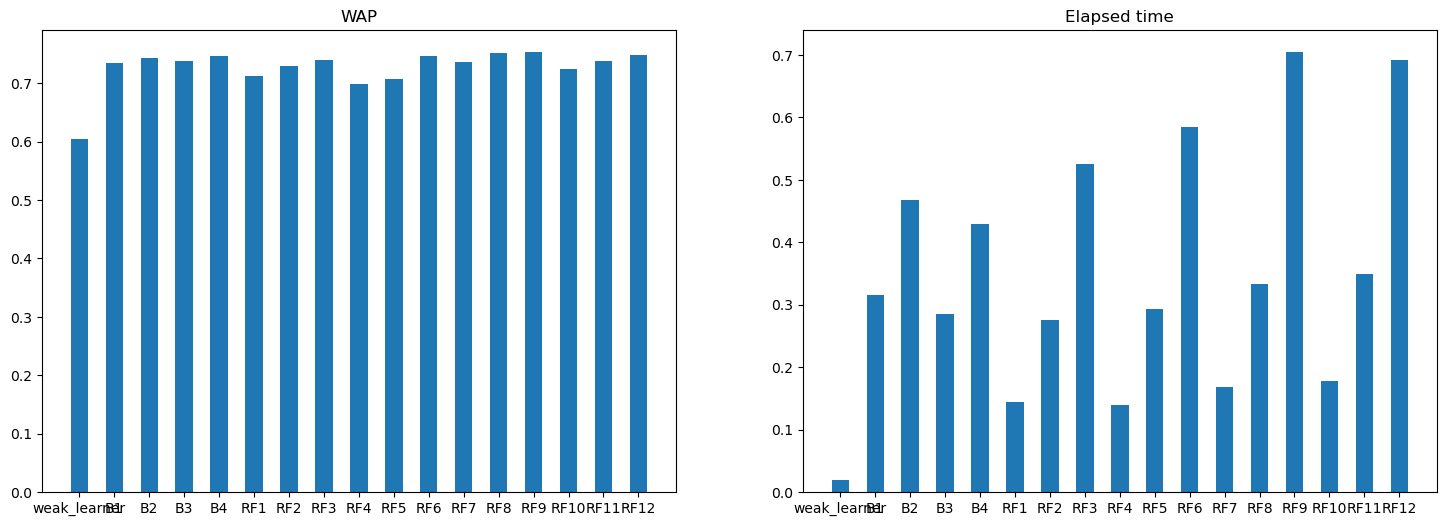

In [39]:
# create a handler for ensemble_test, use the created handler for fitting different models.
ensemble_handler = Evaluator(house_prices)
ensemble_handler.evaluate_model(get_weak_learner(), 'weak_learner')
# Workspace 2.11.a
# TODO Add multiple instances of the ensemble methods. Plot and compare their performance
# You can also add best tree from problem 3
# BEGIN 
# code here
ensemble_handler.evaluate_model(BaggingEnsemble(10, 0.9), 'B1')
ensemble_handler.evaluate_model(BaggingEnsemble(15, 0.9), 'B2')
ensemble_handler.evaluate_model(BaggingEnsemble(10, 0.8), 'B3')
ensemble_handler.evaluate_model(BaggingEnsemble(15, 0.8), 'B4')
ensemble_handler.evaluate_model(RandomForest(25, sample_ratio=0.7, features_ratio=0.1),'RF1')
ensemble_handler.evaluate_model(RandomForest(50, sample_ratio=0.7, features_ratio=0.1),'RF2')
ensemble_handler.evaluate_model(RandomForest(100, sample_ratio=0.7, features_ratio=0.1),'RF3')
ensemble_handler.evaluate_model(RandomForest(25, sample_ratio=0.8, features_ratio=0.1),'RF4')
ensemble_handler.evaluate_model(RandomForest(50, sample_ratio=0.8, features_ratio=0.1),'RF5')
ensemble_handler.evaluate_model(RandomForest(100, sample_ratio=0.8, features_ratio=0.1),'RF6')
ensemble_handler.evaluate_model(RandomForest(25, sample_ratio=0.7, features_ratio=0.15),'RF7')
ensemble_handler.evaluate_model(RandomForest(50, sample_ratio=0.7, features_ratio=0.15),'RF8')
ensemble_handler.evaluate_model(RandomForest(100, sample_ratio=0.7, features_ratio=0.15),'RF9')
ensemble_handler.evaluate_model(RandomForest(25, sample_ratio=0.8, features_ratio=0.15),'RF10')
ensemble_handler.evaluate_model(RandomForest(50, sample_ratio=0.8, features_ratio=0.15),'RF11')
ensemble_handler.evaluate_model(RandomForest(100, sample_ratio=0.8, features_ratio=0.15),'RF12')
ensemble_handler.print_results()
ensemble_handler.plot_metrics()
# END

#### Write-up 2.11.b
#BEGIN

The best weighted average precision of the models I tried was 0.753086, achieved by a random forest that had the largest n_estimators of the values I tried, the smallest sample_ratio and the largest features_ratio. Of the bagging models I tried, the one with the highest n_estimators I tried and the lowest sample_ratio performed the best.

#END

### Problem 3: Multi-class AdaBoost (Bonus) [7 points]

There are different methods of boosting, but we'll focus in this problem on Adaptive Boosting (AdaBoost).
The logic of AdaBoost is to "push" each new learner to give more importance to previously misclassified data. We present
below the multiclass variant of AdaBoost [SAMME](https://web.stanford.edu/~hastie/Papers/samme.pdf). We denote $K$ the number of classes.

AdaBosst is performed by increasing the weights of misclassified samples after each iteration:
- Input: m samples $(X_i, y_i)_{i\in [m]}$, number of boosting rounds $N$
- Start with equal samples weights $W = (w_i), $ where   $w_i = \frac{1}{\texttt{n_samples}}$
- at round j:
    - Train estimator $h_j$ using current weights $W$
    - Get the predicted $(\hat{y}_i)$ on the training data using $h_j$
    - Find the weighted error rate $\epsilon_j$ using $W$: $\epsilon_j=\frac{\sum_i w_i \Delta(\hat{y}_i, y_i)}{\sum_i w_i}$
    - Choose $\alpha_j = \log \frac{1-\epsilon_j}{\epsilon_j} + \log(K-1)$
    - Update $W$ using: $w_i \leftarrow w_i \exp(\alpha_j \Delta(\hat{y_i}, y_i)) $
    - Normalize $W$ to have sum 1
- Global estimator is $H = \sum_j \alpha_j h_j$,

the $\Delta$ function equals to 1 when the two argument are different, 0 otherwise.

To understand how we implement $H$, imaging we have two classes, and we boosted for 3 rounds to get $(h_1, h_2, h_3)$,
with weights $(\alpha_1, \alpha_2, \alpha_3)$. When we want to predict the label of sample $x$, we get $(h_1(x), h_2(x), h_3(x)) = (0,1,0)$.

In this case, label $0$ gets a weight $\alpha_1+\alpha_2$, while class $1$ get weight $\alpha_2$. The predicted class is the one with
the largest weight (1 if $\alpha_2 > \alpha_1 + \alpha_3$, 0 otherwise)

<br>

**Q3.1 (Bonus)** [3 points] Complete `fit` by building `n_estimators` of DecisionTreeClassifier, each trained on the same data but with different samples weights as detailed in the algorithm. Keep track of $(\alpha_i)$

_Hint: our weak learner (DecisionTreeClassifier) can take an argument `sample_weight` when calling the `fit` method, you'll have to use it to provide the weights $W$_
 

**Q3.2 (Bonus)** [3 points] Complete `predict` method: it should handle multi-class labels, this is slighlty different from the binary case seen in the hands on)

Note: Notice that if the estimator is consistent (0 error rate on the training set), AdaBoost $\alpha_j$ are no longer defined. That's why this method requires a **weak** learner.

In [40]:
class AdaBoost(BaggingEnsemble):
    def __init__(self, n_estimators):
        super(AdaBoost, self).__init__(n_estimators)
        self.num_classes = None
        self.alphas = []

    def fit(self, X_train, y_train):
        self.estimators = []
        self.alphas = []
        self.num_classes = np.unique(y_train).shape[0]  # K in the algorithm
        weights = np.ones(len(X_train)) / len(X_train)  # W in the algorithm

        for m in range(self.n_estimators):
            # Workspace 3.1
            # TODO: Implement Multiclass Adaboost and keep track of the alpha_j
            # BEGIN 
            # code here
            model = DecisionTreeClassifier(max_depth=1)
            model.fit(X_train, y_train, sample_weight=weights)
            y_pred = model.predict(X_train)

            epsilon = np.sum(weights * (y_pred != y_train))
            alpha = 0.5 * np.log((1 - epsilon) / epsilon)
            self.alphas.append(alpha)

            weights *= np.exp(-alpha * y_train * y_pred)
            weights /= np.sum(weights)
            self.estimators.append(model)
            # END

    def predict(self, X_test):
        '''
        get the labels returned by the global estimator defined as H
        the predicted label is the one that accumulates the largest sum of alphas
        '''
        # y_hat is one-hot encoding of the multi-class labels
        answer = 0
        # Workspace 3.2
        # BEGIN 
        # code here
        predictions = np.zeros((X_test.shape[0], self.num_classes))
        for alpha, model in zip(self.alphas, self.estimators):
            y_pred = model.predict(X_test)
            predictions[np.arange(X_test.shape[0]), y_pred] += alpha
        answer = np.argmax(predictions, axis=1)
        # END
        return answer

In [41]:
ensemble_handler.evaluate_model(AdaBoost(40), 'AdaBoost')
ensemble_handler.print_results()

           Model       WAP  Execution time
13           RF9  0.753086        0.704593
12           RF8  0.751029        0.333257
16          RF12  0.748971        0.692701
4             B4  0.746914        0.428857
10           RF6  0.746228        0.584399
2             B2  0.742798        0.468018
7            RF3  0.740055        0.525501
3             B3  0.738683        0.284707
15          RF11  0.737997        0.349468
11           RF7  0.735940        0.168734
1             B1  0.734568        0.315021
6            RF2  0.729767        0.276428
14          RF10  0.724966        0.177300
5            RF1  0.712620        0.144232
9            RF5  0.707819        0.293373
8            RF4  0.698217        0.140050
0   weak_learner  0.604252        0.018794
17      AdaBoost  0.510288        0.370009


#####  **Comparison**

- **(Bonus)**  Q3.3 [1 point] Run the same comparison as in 2.11 including AdaBoost.

           Model       WAP  Execution time
0   weak_learner  0.604252        0.017177
4             A4  0.510288        0.068942
5             A5  0.510288        0.136559
6             A6  0.510288        0.267525
7             A7  0.510288        0.567452
8             A8  0.510288        1.049434
9             A9  0.510288        2.067731
10           A10  0.510288        4.428249
11           A11  0.510288        8.520155
12           A12  0.510288       16.768975
13           A13  0.510288       33.891763
1             A1  0.401920        0.009764
2             A2  0.401920        0.018209
3             A3  0.401920        0.036016


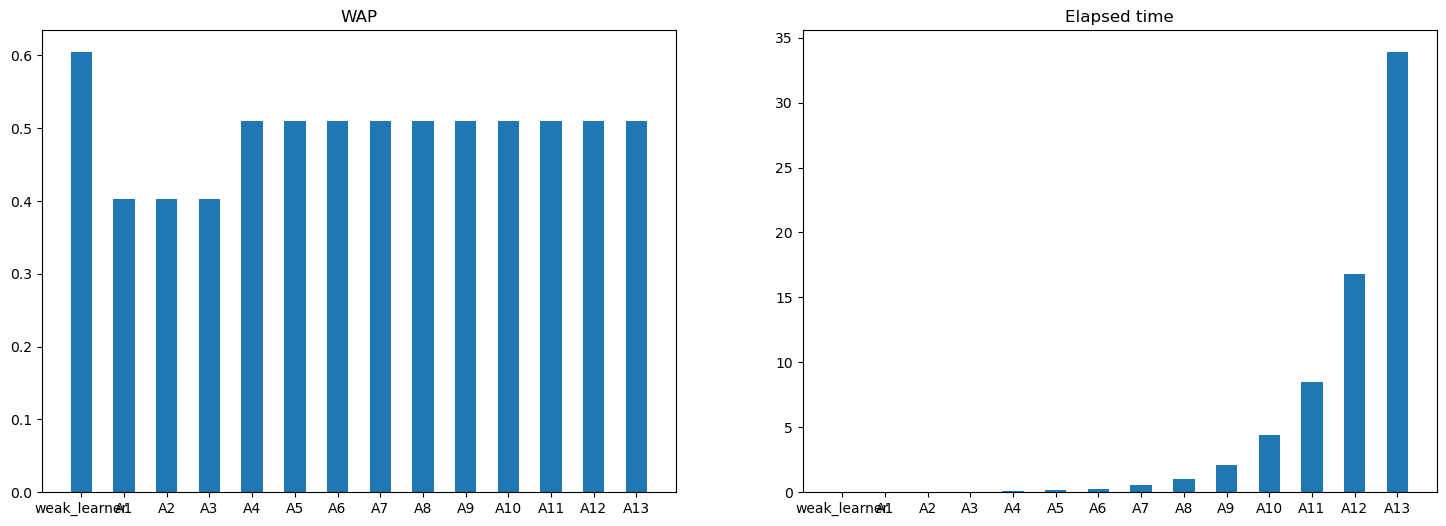

In [45]:
# create a handler for ensemble_test, use the created handler for fitting different models.
ensemble_handler = Evaluator(house_prices)
ensemble_handler.evaluate_model(get_weak_learner(), 'weak_learner')
# Workspace 3.3.a
# TODO Add multiple instances of the ensemble methods. Plot and compare their performance
# BEGIN 
# code here
ensemble_handler.evaluate_model(AdaBoost(1), 'A1')
ensemble_handler.evaluate_model(AdaBoost(2), 'A2')
ensemble_handler.evaluate_model(AdaBoost(4), 'A3')
ensemble_handler.evaluate_model(AdaBoost(8), 'A4')
ensemble_handler.evaluate_model(AdaBoost(16), 'A5')
ensemble_handler.evaluate_model(AdaBoost(32), 'A6')
ensemble_handler.evaluate_model(AdaBoost(64), 'A7')
ensemble_handler.evaluate_model(AdaBoost(128), 'A8')
ensemble_handler.evaluate_model(AdaBoost(256), 'A9')
ensemble_handler.evaluate_model(AdaBoost(512), 'A10')
ensemble_handler.evaluate_model(AdaBoost(1024), 'A11')
ensemble_handler.evaluate_model(AdaBoost(2048), 'A12')
ensemble_handler.evaluate_model(AdaBoost(4096), 'A13')
ensemble_handler.print_results()
ensemble_handler.plot_metrics()
# END

#### Write-up 3.3.b
#BEGIN

% YOUR ANSWER HERE

#END